In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
%matplotlib inline

## load a different set of images

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

File ‘mini_cifar_2.h5’ already there; not retrieving.



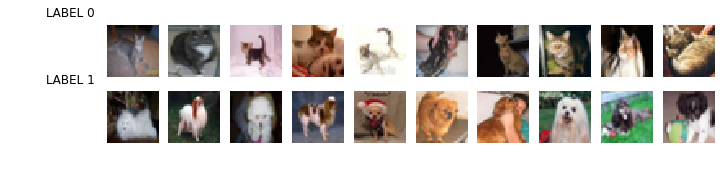

In [3]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]
    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

# 1. Feature Engineering

**Histogram of Oriented Gradients**: See [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

observe how:

- hog is parametrized, in particular `orientations` and `pixels_per_cell`
- a _mini histogram_ for each block is computed counting orientations

In [4]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

def experiment(estimator, x1, y, x2=None, x3=None, n_reps=20, test_size=0.3):
    print("f1")
    tr, ts = mlutils.bootstrapcv(estimator,x1, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
    print("train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr)))
    print("test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts)))
    if x2 is not None:
        print("\nf2")
        tr, ts = mlutils.bootstrapcv(estimator,x2, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
        print("train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr)))
        print("test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts)))
    if x3 is not None:
        print("\nf3")
        tr, ts = mlutils.bootstrapcv(estimator,x3, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
        print("train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr)))
        print("test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts)))

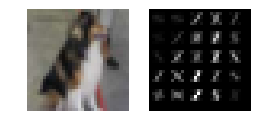

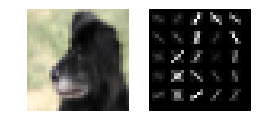

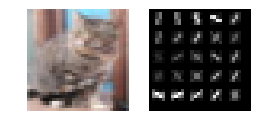

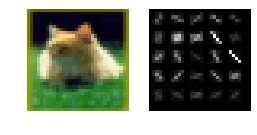

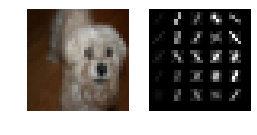

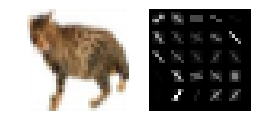

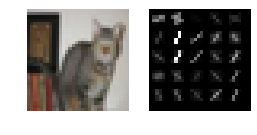

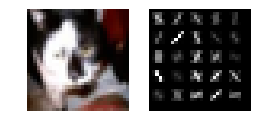

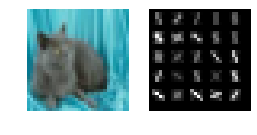

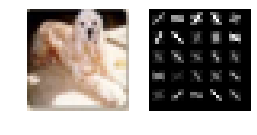

In [5]:
for _ in range(10):
    i = np.random.randint(len(x_cifar))
    img = x_cifar[i]

    fd, hog_image = hog(img, orientations=6, pixels_per_cell=(6, 6), block_norm="L2-Hys",
                        cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)

    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(hog_image,cmap=plt.cm.gray)
    plt.axis("off")

In [6]:
k = pd.Series(y_cifar).value_counts()/len(y_cifar)
print(k)
max_class = np.max(k)

0    0.501765
1    0.498235
dtype: float64


In [7]:
x_cifar_h = np.r_[[hog(img, orientations=6, pixels_per_cell=(6, 6), block_norm="L2-Hys",
                        cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)[0] \
             for img in mlutils.pbar()(x_cifar)]]

100% (1983 of 1983) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


In [8]:
x_cifar_h.shape

(1983, 150)

f1
train score: 0.842 (+- 0.00706)
test score:  0.624 (+- 0.01550)


100% (9 of 9) |##########################| Elapsed Time: 0:00:43 Time:  0:00:43


(0.4, 1)

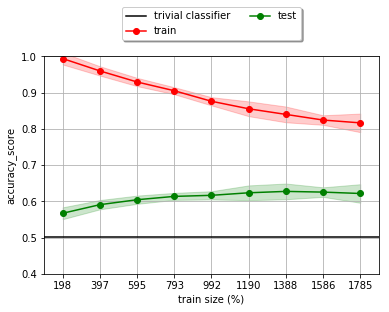

In [9]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_h, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_h, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

# 2. Feature Learning

we will use the features learnt after transfer learning on a **different** dataset

### load model from lesson on transfer learning

In [10]:
from tensorflow.keras.models import load_model
model = load_model("alexnet_finetuned_minicifar.model")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)    

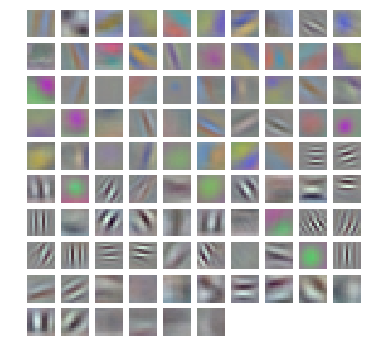

In [11]:
w = model.get_weights()
mlutils.display_imgs(w[0])

### observe how we obtain the activations and output produced by an image

In [12]:
layer_names = [i.name for i in model.layers]
layer_names

['input_1',
 'conv2d',
 'max_pooling2d',
 'conv2d_1',
 'flatten',
 'dropout',
 'dense',
 'dropout_1',
 'output_1']

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
__________

In [14]:
mlutils.get_activations(model, img.reshape(-1,32,32,3), layer_name="flatten")

{'flatten/Reshape:0': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.37831753, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.07498637,
         0.        , 0.        , 0.23845443, 2.5337389 , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.5820049 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.4788574 , 0.        , 0.        , 0.        , 0.        ,
         1.2231327 , 0.        , 0.        , 0.6416656 , 2.583413  ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.992521  , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.2897538 , 1.6372106 ]],
       dtype=float32)}

In [15]:
mlutils.get_activations(model, img.reshape(-1,32,32,3), layer_name="dense")

{'dense/Relu:0': array([[0.        , 1.0866511 , 0.85072005, 0.        , 0.        ,
         0.        , 0.38527867, 0.        , 1.4587051 , 2.206276  ,
         0.        , 0.23699702, 0.        , 0.        , 0.        ,
         0.63815117]], dtype=float32)}

### we now get activations at last layer for the full dataset

In [16]:
x_cifar_f1 = mlutils.get_activations(model, x_cifar, layer_name="dense")
x_cifar_f1 = x_cifar_f1[list(x_cifar_f1.keys())[0]]
x_cifar_f1.shape

(1983, 16)

### and use traditional methods

### start experiments

In [17]:
estimator = SVC(gamma=.1)
r = cross_validate(estimator, x_cifar_f1, y_cifar, cv=5, return_train_score=True)
r

{'fit_time': array([0.21204638, 0.19044566, 0.19358516, 0.19546342, 0.18547106]),
 'score_time': array([0.03886056, 0.03827953, 0.03805709, 0.03665519, 0.0478673 ]),
 'test_score': array([0.49622166, 0.54911839, 0.52644836, 0.56060606, 0.53535354]),
 'train_score': array([0.64627995, 0.65321564, 0.65762926, 0.64902331, 0.65406427])}

In [18]:
print("train score: %.3f (+- %.5f)"%(np.mean(r["train_score"]), np.std(r["train_score"])))
print("test score:  %.3f (+- %.5f)"%(np.mean(r["test_score"]), np.std(r["test_score"])))

train score: 0.652 (+- 0.00397)
test score:  0.534 (+- 0.02201)


In [19]:
experiment(estimator, x_cifar_f1, y_cifar)

f1
train score: 0.655 (+- 0.00664)
test score:  0.529 (+- 0.01536)


100% (9 of 9) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19


(0.4, 1)

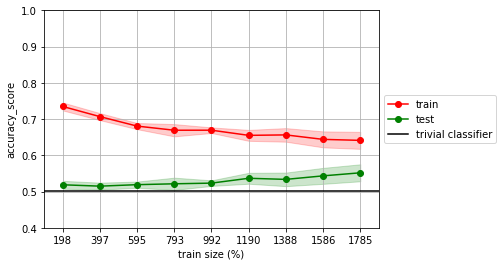

In [20]:
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.axhline(max_class, color="black", label="trivial classifier")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.4,1)

f1
train score: 0.846 (+- 0.00685)
test score:  0.510 (+- 0.01782)


100% (9 of 9) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


(0.4, 1)

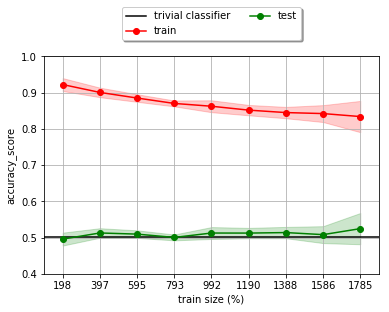

In [21]:
estimator = SVC(gamma=.7)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.667 (+- 0.01645)
test score:  0.511 (+- 0.01436)


100% (9 of 9) |##########################| Elapsed Time: 0:00:09 Time:  0:00:09


(0.4, 1)

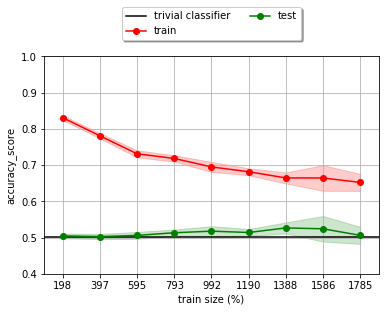

In [22]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.945 (+- 0.00907)
test score:  0.510 (+- 0.01542)


100% (9 of 9) |##########################| Elapsed Time: 0:00:13 Time:  0:00:13


(0.4, 1)

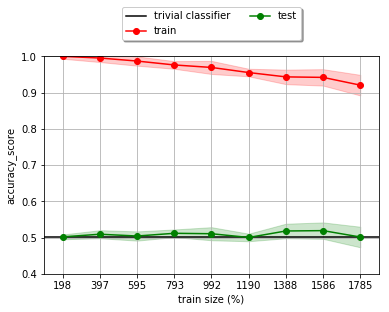

In [23]:
estimator = RandomForestClassifier(max_depth=10, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

### use activations at the output of convolution (flattened)

sometimes we obtain a little improvement over the preovious experiment

In [24]:
x_cifar_f2 = mlutils.get_activations(model, x_cifar, layer_name="flatten")
x_cifar_f2 = x_cifar_f2[list(x_cifar_f2.keys())[0]]
x_cifar_f2.shape

(1983, 60)

f1
train score: 0.655 (+- 0.00840)
test score:  0.523 (+- 0.01769)

f2
train score: 0.905 (+- 0.00558)
test score:  0.535 (+- 0.01598)


100% (9 of 9) |##########################| Elapsed Time: 0:00:25 Time:  0:00:25


(0.4, 1)

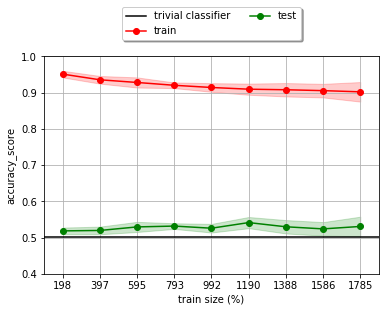

In [25]:
estimator = SVC(gamma=.1)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f2, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.671 (+- 0.01071)
test score:  0.513 (+- 0.01975)

f2
train score: 0.694 (+- 0.01282)
test score:  0.547 (+- 0.01696)


100% (9 of 9) |##########################| Elapsed Time: 0:00:12 Time:  0:00:12


(0.4, 1)

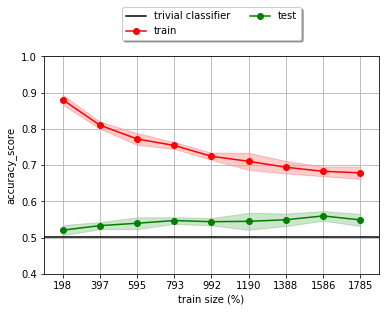

In [26]:
estimator = RandomForestClassifier(max_depth=4,  n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f2, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## collate activations and use them alltogether

In [27]:
x_cifar_f3 = np.hstack((x_cifar_f1, x_cifar_f2))
x_cifar_f1.shape, x_cifar_f2.shape, x_cifar_f3.shape

((1983, 16), (1983, 60), (1983, 76))

f1
train score: 0.652 (+- 0.00534)
test score:  0.537 (+- 0.02122)

f2
train score: 0.909 (+- 0.00405)
test score:  0.530 (+- 0.01677)

f3
train score: 0.926 (+- 0.00511)
test score:  0.528 (+- 0.01097)


100% (9 of 9) |##########################| Elapsed Time: 0:00:39 Time:  0:00:39


(0.4, 1)

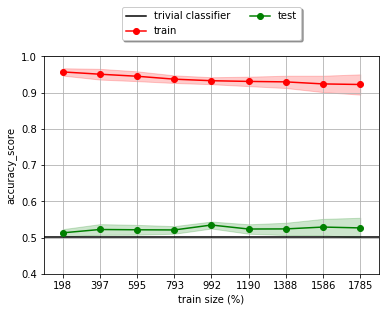

In [28]:
estimator = SVC(gamma=.1)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2, x_cifar_f3)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f3, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.666 (+- 0.01876)
test score:  0.513 (+- 0.01770)

f2
train score: 0.688 (+- 0.00850)
test score:  0.547 (+- 0.01661)

f3
train score: 0.709 (+- 0.00978)
test score:  0.547 (+- 0.01417)


100% (9 of 9) |##########################| Elapsed Time: 0:00:18 Time:  0:00:18


(0.4, 1)

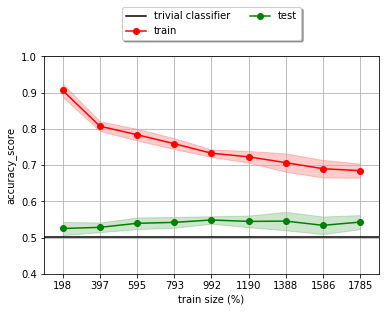

In [29]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2, x_cifar_f3)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f3, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## Finally, we use the features learnt and those engineered together

In [30]:
x_cifar_f4 = np.hstack((x_cifar_f1, x_cifar_h))
x_cifar_f4.shape

(1983, 166)

f1
train score: 0.844 (+- 0.00994)
test score:  0.624 (+- 0.01558)


100% (9 of 9) |##########################| Elapsed Time: 0:00:30 Time:  0:00:30


(0.4, 1)

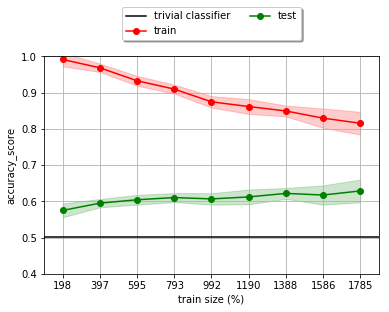

In [31]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f4, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f4, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## Observe that

- performance is somewhat lower than in the transfer learning lab $\rightarrow$ a dense network is performing better on output features.
- however, now we can build learning curves, experiment faster
- performance for HOG is better, we have small images and little computation of the convolutional network

- **suggested**: create a dense network in Keras and feed the activations `x_cifar_2` or `x_cifar_ 3` 
